# Earth Lab Capstone Project: Exploring patterns between soil moisture and rainfall in the western US using satellite observations.

## Author: Jacquelyn Witte

## This Notebook examines the relationship between SMAP and ESA CCI soil moisture and GPM daily and IMERG 30min precipitation for Landslides in the US

#### Note: Uses CSV data files exported by the landslide_precip_soilm_DataExport_final.ipynb

- Based on 2015-2020 Landslide events from the NASA Global Landslide Catalog (GLC)
- Using Landslide locations over Colorado as a workflow example
- Workflow can be applied to any USA state defined in the GLC

In [1]:
# Override saving plots
GLOBAL_CACHE_OVERRIDE = False

In [2]:
import os
from glob import glob

import earthpy as et
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Prettier plotting with seaborn
sns.set(font_scale=1.2)

In [3]:
def leastsq(x, y, method=3):
    """
    5 methods to compute least squares fit.

    Reference: https://github.com/sbird/spb_common/blob/master/leastsq.py
    Compute the least squares fit to y = beta x + alpha,
    using one of the 5 methods outlined in
    http://adsabs.harvard.edu/abs/1990ApJ...364..104I
    Method 1 minimises distance from Y given X (ie, the standard least squares fit)
    Method 2 minimises distance from X given Y
    Method 3 (recommended) is the OLS bisector, which gives a line bisecting the above two.
    Method 4 (Orthogonal regression) minimises perpendicular distance from the line to points
    Method 5 is the geometric mean of the slopes from methods 1 and 2.
    Method 6 is the Theil-Sen estimator: the median of the pairwise slopes.
    (See Akritas 95,  http://www.tandfonline.com/doi/abs/10.1080/01621459.1995.10476499)

    Parameters
    ----------
    x, y: numeric array

    Returns
    -------
    (alpha, beta, bvar), the intercept slope and variance of the slope
    """
    # Define some sums
    xbar = np.mean(x)
    ybar = np.mean(y)
    xdif = x-xbar
    ydif = y-ybar
    sxx = np.sum(xdif**2)
    syy = np.sum(ydif**2)
    sxy = np.sum(ydif*xdif)

    # Check for zeros
    if sxx == 0 or syy == 0 or sxy == 0:
        raise ValueError("Least Squares ill-defined")
    if method > 6 or method < 1:
        raise ValueError("Method not recognised")

    # These formulas are taken from Table 1 of Isobe et al, page 3
    # Minimise distance from Y given X
    beta1 = sxy/sxx
    # Variance of b1
    bvar1 = np.sum(xdif**2*(ydif-beta1*xdif)**2)/sxx**2
    # Minimise distance from X given Y
    beta2 = syy/sxy
    # Variance of b2
    bvar2 = np.sum(ydif**2*(ydif-beta2*xdif)**2)/sxy**2
    # Covariance of b1 and b2
    covb12 = np.sum(xdif*ydif*(ydif-beta2*xdif) *
                    (ydif-beta1*xdif))/(beta1*sxx**2)

    if method == 1:
        beta = beta1
        bvar = bvar1
    if method == 2:
        beta = beta2
        bvar = bvar2
    if method == 3:
        # OLS bisector: line that bisects the above two.
        beta1p1 = 1+beta1**2
        beta2p1 = 1+beta2**2
        beta = (beta1*beta2 - 1 + np.sqrt(beta1p1*beta2p1))/(beta1+beta2)
        # Variance
        prefac = beta**2 / ((beta1 + beta2)**2 * beta1p1 * beta2p1)
        var = (beta2p1**2 * bvar1 + 2 * beta1p1 * beta2p1 
               * covb12 + beta1p1**2 * bvar2)
        bvar = prefac*var

    if method == 4:
        # Orthogonal: minimise perpendicular distance from line to points
        beta = 0.5*((beta2-1./beta1)+np.sign(sxy) *
                    np.sqrt(4+(beta2-1./beta1)**2))
        prefac = beta**2 / (4*beta1**2 + (beta1*beta2 - 1)**2)
        bvar = prefac * (bvar1/beta1**2 + 2*covb12 + beta1**2*bvar2)

    if method == 5:
        # Reduced major axis:
        beta = np.sign(sxy)*np.sqrt(beta1*beta2)
        bvar = 0.25 * (beta2/beta1 * bvar1 + 2*covb12 + beta1/beta2 * bvar2)

    if method == 6:
        # Theil-Sen estimator for uncensored data: the median of the slopes.
        yy = np.subtract.outer(y, y)
        xx = np.subtract.outer(x, x)
        ind = np.where(xx != 0)
        beta = np.median(yy[ind]/xx[ind])
        # Can't find a formula for the variance
        bvar = 0

    # The intercept
    alpha = ybar - beta*xbar

    return (alpha, beta, bvar)

### Choose the US state 

In [4]:
westernUS = ['Colorado', 'Utah', 'Idaho',
             'California', 'Oregon', 'Washington']
state = westernUS[0]

### Find and open the csv files to dataFrames

In [5]:
data_file = os.path.join('data', 
                         'glc_smap_esa_gpm_2015-2020_'+state+'.csv')

data_file_7d = os.path.join('data', 
                         'glc_smap_esa_gpm_2015-2020_7day_'+state+'.csv')

try: 
    landslide_df = pd.read_csv(data_file, index_col='date')
    landslide_precip7d_df = pd.read_csv(data_file_7d, index_col='date')
    
    # convert time_date col to datetime64 dtype
    landslide_precip7d_df.index = pd.to_datetime(landslide_precip7d_df.index)
    landslide_df.index = pd.to_datetime(landslide_df.index)
except IOError:
    print("Bad file name: "+data_file) 

landslide_df.head()

,smap_sm,veg_water_content,esa_sm_percent,gpm_7day_accum_mm,gpm_7day_max_mm,ksat_log10cm/hr,clay_%,sand_%,silt_%,glc_lat,glc_lon,landslide_id,landslide_category,landslide_trigger,landslide_size,gpm_7day_accum_norm,imerg_7day_accum_mm,imerg_7day_max_mm
date,,,,,,,,,,,,,,,,,,
2015-04-27,0.317197,6.890422,69.368736,NaN,NaN,0.452758,13.5,39.5,37.5,40.4802,-106.8393,6994,landslide,continuous_rain,medium,1.619263,NaN,NaN
2015-05-11,0.272764,7.326808,77.626862,17.172499,7.465425,-0.232061,29.5,35.5,33.5,39.7790,-105.2274,7047,mudslide,continuous_rain,small,1.132590,NaN,NaN
2015-05-13,0.313212,5.688665,49.098743,33.419148,21.057816,-0.505989,33.5,18.5,36.5,38.9218,-104.8365,7060,landslide,continuous_rain,small,1.711564,NaN,NaN
2015-05-19,0.302068,4.655353,44.547489,9.885129,7.639515,0.932131,21.5,34.5,17.5,38.2967,-105.2706,7051,mudslide,continuous_rain,small,1.675332,NaN,NaN
2015-05-19,0.285023,2.794569,68.619576,22.491661,16.875399,0.452758,22.5,58.5,35.5,38.5526,-105.0948,7053,landslide,continuous_rain,medium,1.132590,NaN,NaN


In [6]:
landslide_precip7d_df.head()

,gpm_precip_mm,landslide_id,smap_sm,esa_vol,gpm_7day_accum_mm,days-to-landslide,imerg_precip_mm
date,,,,,,,
2015-04-27,0.143790,6994,0.277666,69.368736,9.568942,7,NaN
2015-04-26,0.068229,6994,0.269774,NaN,9.255543,6,NaN
2015-04-25,0.004842,6994,NaN,54.474586,9.041108,5,NaN
2015-04-24,0.022953,6994,0.317197,NaN,6.744161,4,NaN
2015-04-23,0.090758,6994,NaN,55.441750,4.189932,3,NaN


### Plot the cumulative precipitation going back 7 days

In [7]:
# calculate the number of landslides per year
landslide_count = landslide_precip7d_df.groupby(
                                        landslide_precip7d_df.index.year
                                        )['smap_sm'].nunique().values.tolist()
print(landslide_count)
# year = np.arange(len(landslide_count))+2015
year = []
for i, df in landslide_df.groupby(landslide_df.index.year):
    year.append(df.index.year[0])

colors = ['dodgerblue',  'orange', 'firebrick', 'forestgreen', 'cyan', 'purple']
year_count = []
for i, yr in enumerate(year):
    year_count.append(str(yr)+' ('+str(landslide_count[i])+')')

landslide_dict = dict(zip(year_count, colors))
color_dict = dict(zip(year, colors))

print(landslide_dict)
print(color_dict)

[30, 21, 22, 8, 4, 4]
{'2015 (30)': 'dodgerblue', '2016 (21)': 'orange', '2017 (22)': 'firebrick', '2018 (8)': 'forestgreen', '2019 (4)': 'cyan', '2020 (4)': 'purple'}
{2015: 'dodgerblue', 2016: 'orange', 2017: 'firebrick', 2018: 'forestgreen', 2019: 'cyan', 2020: 'purple'}


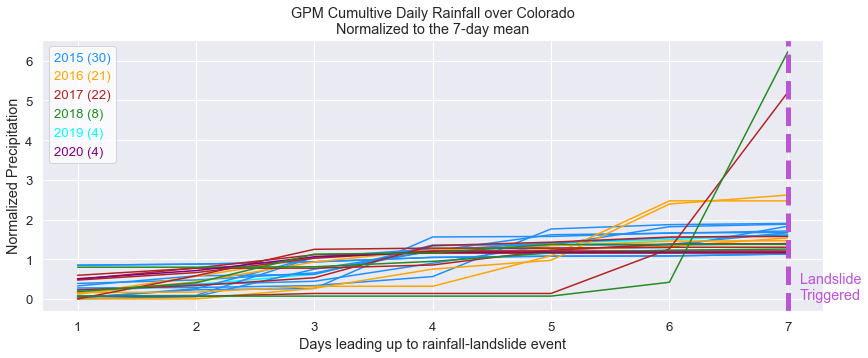

In [8]:
fig, ax = plt.subplots(figsize=(14, 5), sharex=True, sharey=True)

for id, df in landslide_precip7d_df.groupby('landslide_id'):
    result = df['gpm_7day_accum_mm']/df['gpm_7day_accum_mm'].mean()
    if result.max() > 1.1:
        ax.plot(df['days-to-landslide'], result,
                color=color_dict[result.index.year[0]])

# Add legend
leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True,
                labels=landslide_dict, labelcolor=color_dict.values(),
                facecolor='white')
for item in leg.legendHandles:
    item.set_visible(False)

# ax.invert_xaxis()
ax.axvline(x=7, ymin=0, color='mediumorchid', linestyle='dashed', linewidth=5)

ax.set(xlabel='Days leading up to rainfall-landslide event',
       ylabel='Normalized Precipitation',
       title=('GPM Cumultive Daily Rainfall over '
              + state+'\nNormalized to the 7-day mean'))
ax.text(7.1, 0, 'Landslide\nTriggered',
        color='mediumorchid', fontsize='medium')

# output the figure
output_fig = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'capstone-landslides-soilmoisture', 'plots',
                        'gpm_precip7d_normalized_timeseries_'+state+'.png')

cache_override = False or GLOBAL_CACHE_OVERRIDE
if not os.path.exists(output_fig) or cache_override:
    plt.savefig(output_fig)

### Plot Precipitation vs SMAP Soil Moisture

In [9]:
category = dict(zip(np.unique(landslide_df['landslide_category']), colors))
print(category)

trigger = dict(zip(np.unique(landslide_df['landslide_trigger']), colors))
print(trigger)

{'debris_flow': 'dodgerblue', 'landslide': 'orange', 'mudslide': 'firebrick', 'rock_fall': 'forestgreen'}
{'continuous_rain': 'dodgerblue', 'downpour': 'orange', 'rain': 'firebrick'}


#### Plot by Landslide Category

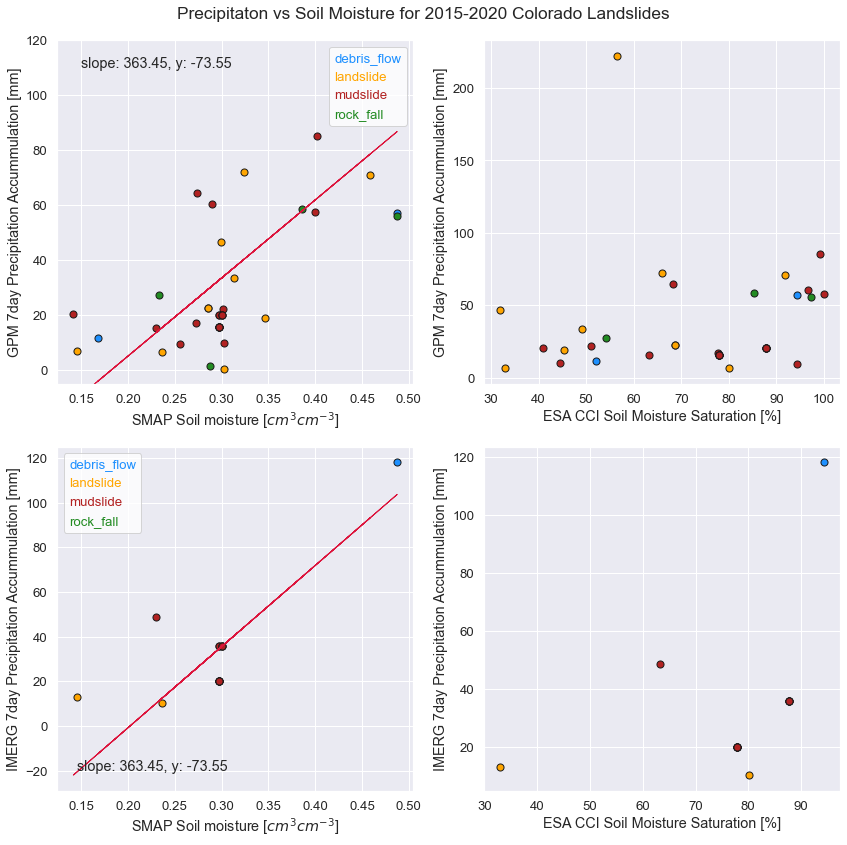

In [10]:
# Create a scatter plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, 
                                             figsize=(12, 12))

# GPM daily precip vs SMAP & ESA
for id, df in landslide_df.groupby("landslide_id"):
    for cat in category:
        if df['landslide_category'][0] == cat:
            ax1.scatter(df['smap_sm'], df['gpm_7day_accum_mm'],
                        edgecolor='k', s=50.0,
                        color=category[cat])
            ax2.scatter(df['esa_sm_percent'], df['gpm_7day_accum_mm'],
                        edgecolor='k', s=50.0,
                        color=category[cat])

# calculate the linear trend for Colorado only
if state == 'Colorado':
    idx = ( np.isfinite(landslide_df['smap_sm']) 
            & np.isfinite(landslide_df['gpm_7day_accum_mm'])
           )
    # defining the variables
    x = landslide_df['smap_sm'][idx].tolist()
    y = landslide_df['gpm_7day_accum_mm'][idx].tolist()
    # Calculate the OLR Bisector fit
    intercept, slope, var = leastsq(x, y, method=3)
    trend_mean_text = 'slope: '+str('{:.2f}'.format(slope)) + \
          ', y: '+str('{:.2f}'.format(intercept))

    # plot the linear trend
    ax1.plot(landslide_df['smap_sm'],
             intercept + slope*landslide_df['smap_sm'],
             color='crimson',
             linewidth=1.0)

ax1.set(xlabel='SMAP Soil moisture [$cm^3 cm^{-3}$]',
        ylabel='GPM 7day Precipitation Accummulation [mm]')

ax2.set(xlabel='ESA CCI Soil Moisture Saturation [%]',
        ylabel='GPM 7day Precipitation Accummulation [mm]')

# Add legend
leg = ax1.legend(handlelength=0, handletextpad=0, fancybox=True,
                 labels=category, labelcolor=colors, facecolor='white')
for item in leg.legendHandles:
    item.set_visible(False)

# add an overall caption
fig.suptitle(
    'Precipitaton vs Soil Moisture for 2015-2020 '+state+' Landslides'
)

# IMERG 30min precip vs SMAP & ESA
for id, df in landslide_df.groupby("landslide_id"):
    for cat in category:
        if df['landslide_category'][0] == cat:
            ax3.scatter(df['smap_sm'], df['imerg_7day_accum_mm'],
                        edgecolor='k', s=50.0,
                        color=category[cat])
            ax4.scatter(df['esa_sm_percent'], df['imerg_7day_accum_mm'],
                        edgecolor='k', s=50.0,
                        color=category[cat])

ax3.set(xlabel='SMAP Soil moisture [$cm^3 cm^{-3}$]',
        ylabel='IMERG 7day Precipitation Accummulation [mm]')
#ax3.set_ylim([-5, 120])

ax4.set(xlabel='ESA CCI Soil Moisture Saturation [%]',
        ylabel='IMERG 7day Precipitation Accummulation [mm]')

# calculate the linear trend
idx = ( np.isfinite(landslide_df['smap_sm']) 
        & np.isfinite(landslide_df['imerg_7day_accum_mm'])
       )
# defining the variables
x = landslide_df['smap_sm'][idx].tolist()
y = landslide_df['imerg_7day_accum_mm'][idx].tolist()
# Calculate the OLR Bisector fit
intercept, slope, var = leastsq(x, y, method=3)
trend_mean_text = 'slope: '+str('{:.2f}'.format(slope)) + \
      ', y: '+str('{:.2f}'.format(intercept))

# plot the linear trend
if state == 'Colorado':
    ax3.plot(landslide_df['smap_sm'],
             intercept + slope*landslide_df['smap_sm'],
             color='crimson',
             linewidth=1.0)
    ax1.set_ylim(-5, 120)
    ax1.text(0.15, 110, trend_mean_text)
    ax3.text(min(x), -20, trend_mean_text)

# Add legend
leg = ax3.legend(handlelength=0, handletextpad=0, fancybox=True,
                 labels=category, labelcolor=colors, facecolor='white')
for item in leg.legendHandles:
    item.set_visible(False)

    
plt.tight_layout()

# output the figure
output_fig = os.path.join(et.io.HOME,
                          'earth-analytics',
                          'capstone-landslides-soilmoisture', 'plots',
                          'sm_VS_precip_2015_2020_category_'+state+'.png')

cache_override = False or GLOBAL_CACHE_OVERRIDE
if not os.path.exists(output_fig) or cache_override:
    plt.savefig(output_fig)

### Scatter plots - Maximum precipitation intensity vs soil moisture 7 day difference

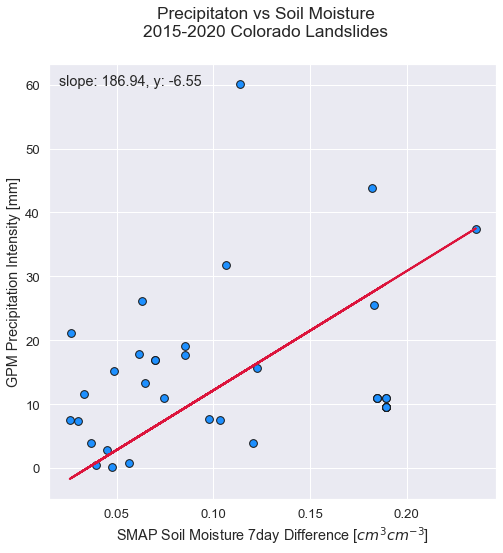

In [11]:
# Create a scatter plot
fig, ax = plt.subplots(figsize=(8,8))

# GPM daily Pre3cip vs SMAP & ESA
xdata = []
ydata = []
for id, df in landslide_precip7d_df.groupby("landslide_id"):
    if state == 'Colorado':
        if df['gpm_precip_mm'].max() < 150.:
            ax.scatter((df['smap_sm'].max()-df['smap_sm'].min()), 
               df['gpm_precip_mm'].max(), 
               color='dodgerblue', edgecolor='k', s=60.0)
            xdata.append(df['smap_sm'].max()-df['smap_sm'].min())
            ydata.append(df['gpm_precip_mm'].max())
    else:
        ax.scatter((df['smap_sm'].max()-df['smap_sm'].min()), 
               df['gpm_precip_mm'].max(), 
               color='dodgerblue', edgecolor='k', s=60.0)
        xdata.append(df['smap_sm'].max()-df['smap_sm'].min())
        ydata.append(df['gpm_precip_mm'].max()) 
    

# Calculate the OLR Bisector fit
intercept, slope, var = leastsq(xdata, ydata, method=5)

trend_mean_text = 'slope: '+str('{:.2f}'.format(slope)) + \
      ', y: '+str('{:.2f}'.format(intercept))


# plot the linear trend
ax.plot(np.array(xdata),
         intercept + slope*np.array(xdata),
         color='crimson',
         linewidth=2.0)
if state == 'Colorado':
    ax.text(0.02, 60, trend_mean_text);
else:
    ax.text(0.02, landslide_precip7d_df['gpm_precip_mm'].max(), 
            trend_mean_text);

# Add titles
ax.set(xlabel='SMAP Soil Moisture 7day Difference [$cm^3 cm^{-3}$]',
        ylabel='GPM Precipitation Intensity [mm]');

# add an overall caption
fig.suptitle(
    'Precipitaton vs Soil Moisture\n2015-2020 '+state+' Landslides'
);

#output the figure
output_fig = os.path.join(et.io.HOME,
            'earth-analytics',
            'capstone-landslides-soilmoisture', 'plots',
            'smdiff_VS_precipintensity_2015_2020_'+state+'.png')

cache_override = False or GLOBAL_CACHE_OVERRIDE
if not os.path.exists(output_fig) or cache_override:
    plt.savefig(output_fig);

### Scatter plot - Ksat (Saturated Hydraulic Conductivity) vs soil moisture

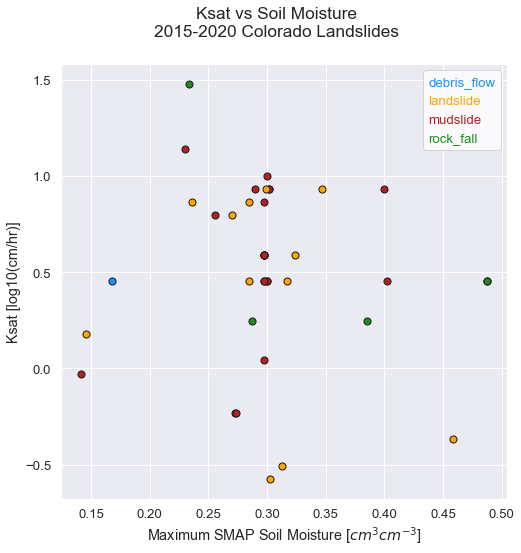

In [12]:
# Create a scatter plot
fig, ax = plt.subplots(figsize=(8, 8))

# GPM daily precip vs SMAP & ESA
for id, df in landslide_df.groupby("landslide_id"):
    for cat in category:
        if df['landslide_category'][0] == cat:
            ax.scatter(df['smap_sm'], df['ksat_log10cm/hr'],
                        edgecolor='k', s=50.0,
                        color=category[cat])
# Add legend
leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True,
                 labels=category, labelcolor=colors, facecolor='white')
for item in leg.legendHandles:
    item.set_visible(False)

# Add titles
ax.set(xlabel='Maximum SMAP Soil Moisture [$cm^3 cm^{-3}$]',
       ylabel='Ksat [log10(cm/hr)]')

# add an overall caption
fig.suptitle(
    'Ksat vs Soil Moisture\n2015-2020 '+state+' Landslides'
);
 

### Look at outliers by creating box-whisker plots

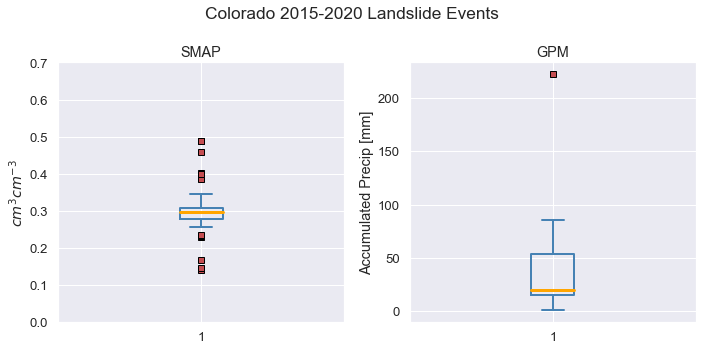

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

red_sqr = dict(markerfacecolor='r', marker='s')

# Data may contain NaN - these have to be removed for boxplot() to work
filtered_data = landslide_df['smap_sm'][~np.isnan(landslide_df['smap_sm'])]

axs[0].boxplot(filtered_data, flierprops=red_sqr,
            whiskerprops = dict(linestyle='-',linewidth=2., color='steelblue'),
            boxprops = dict(linestyle='-',linewidth=2., color='steelblue'),
            medianprops = dict(linestyle='-',linewidth=3., color='orange'),
            capprops = dict(linestyle='-',linewidth=2., color='steelblue')
            )
axs[0].set(title='SMAP',
          ylabel='$cm^3 cm^{-3}$')

axs[0].set_ylim([0, 0.7])

filtered_data = landslide_df['gpm_7day_accum_mm'][
                                ~np.isnan(landslide_df['gpm_7day_accum_mm'])]
axs[1].boxplot(filtered_data, flierprops=red_sqr,
            whiskerprops = dict(linestyle='-',linewidth=2., color='steelblue'),
            boxprops = dict(linestyle='-',linewidth=2., color='steelblue'),
            medianprops = dict(linestyle='-',linewidth=3., color='orange'),
            capprops = dict(linestyle='-',linewidth=2., color='steelblue')
            )
axs[1].set(title='GPM',
          ylabel='Accumulated Precip [mm]')

plt.suptitle(state+' 2015-2020 Landslide Events')

plt.tight_layout()

output_fig = os.path.join(et.io.HOME,
            'earth-analytics',
            'capstone-landslides-soilmoisture', 'plots',
            'sm_precip_2015_2020_boxplot_'+state+'.png')

#output the figure
cache_override = False or GLOBAL_CACHE_OVERRIDE
if not os.path.exists(output_fig) or cache_override:
    plt.savefig(output_fig);

### Plot of POLARIS soil parameters

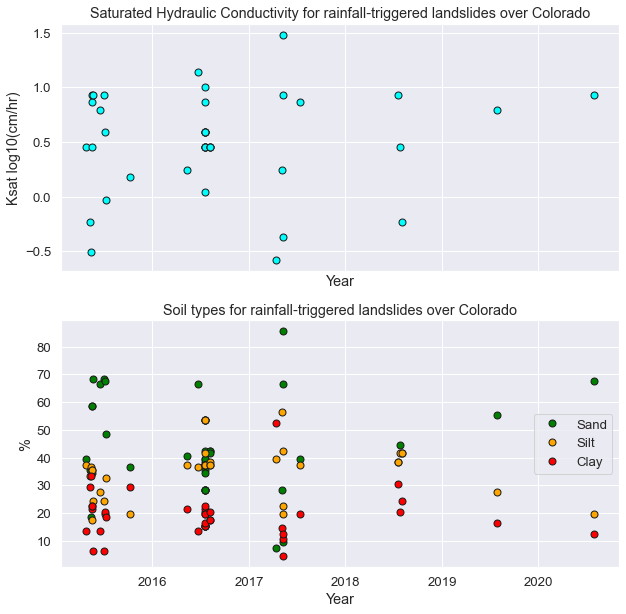

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, 
                                    figsize=(10, 10), sharex=True) 
ax1.plot(landslide_df['ksat_log10cm/hr'], marker='o', 
        linestyle='None', color='cyan', markersize=7, markeredgecolor='k')
ax1.set(xlabel='Year',
       ylabel='Ksat log10(cm/hr)',
       title=('Saturated Hydraulic Conductivity for rainfall-triggered landslides over '+state)
      );

ax2.plot(landslide_df['sand_%'], marker='o', 
        linestyle='None', color='green', 
        markersize=7, markeredgecolor='k',
        label='Sand')
ax2.plot(landslide_df['silt_%'], marker='o', 
        linestyle='None', color='orange', 
        markersize=7, markeredgecolor='k',
        label='Silt');
ax2.plot(landslide_df['clay_%'], marker='o', 
        linestyle='None', color='red',
        markersize=7, markeredgecolor='k',
        label='Clay');

ax2.set(xlabel='Year',
       ylabel='%',
       title='Soil types for rainfall-triggered landslides over '+state);
ax2_ylim = (0, 100)

ax2.legend();

# output plot
output_fig = os.path.join(et.io.HOME,
            'earth-analytics',
            'capstone-landslides-soilmoisture', 'plots',
            'polaris_soiltype_2015_2020_'+state+'.png')

#output the figure
cache_override = False or GLOBAL_CACHE_OVERRIDE
if not os.path.exists(output_fig) or cache_override:
    plt.savefig(output_fig);